# Face_Expression_Recognition

In [1]:
# Step 1: Import necessary libraries
import os
import cv2
import numpy as np
import zipfile
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img # type: ignore
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D # type: ignore
from tensorflow.keras.models import load_model, Sequential # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

# Suppress warnings (Optional), to reduce noise during the run.
import warnings
warnings.filterwarnings("ignore")

### **STEP 2: EDA - Load & Unzip the Dataset & Display Sample Images**
<b>`zipfile.ZipFil()`</b> :
    - Used to extract files from a zip archive.

<b>`zip_ref`</b> :
    - Used to reference the zip file during extraction.

<b>`zip_ref.extractall()`</b> :
    - Used to extract all files from a zip archive, simplifying the process of working with compressed files.

In [2]:
# Paths to the zip files
FACE_EXPRESSION_ZIP = "/content/Face_expression_recognition_dataset.zip"

# Unzip the dataset
with zipfile.ZipFile(FACE_EXPRESSION_ZIP, 'r') as zip_ref:
    zip_ref.extractall("Face_expression_recognition_dataset") # Extract all files from a zip archive and simplify the process of working with compressed files.

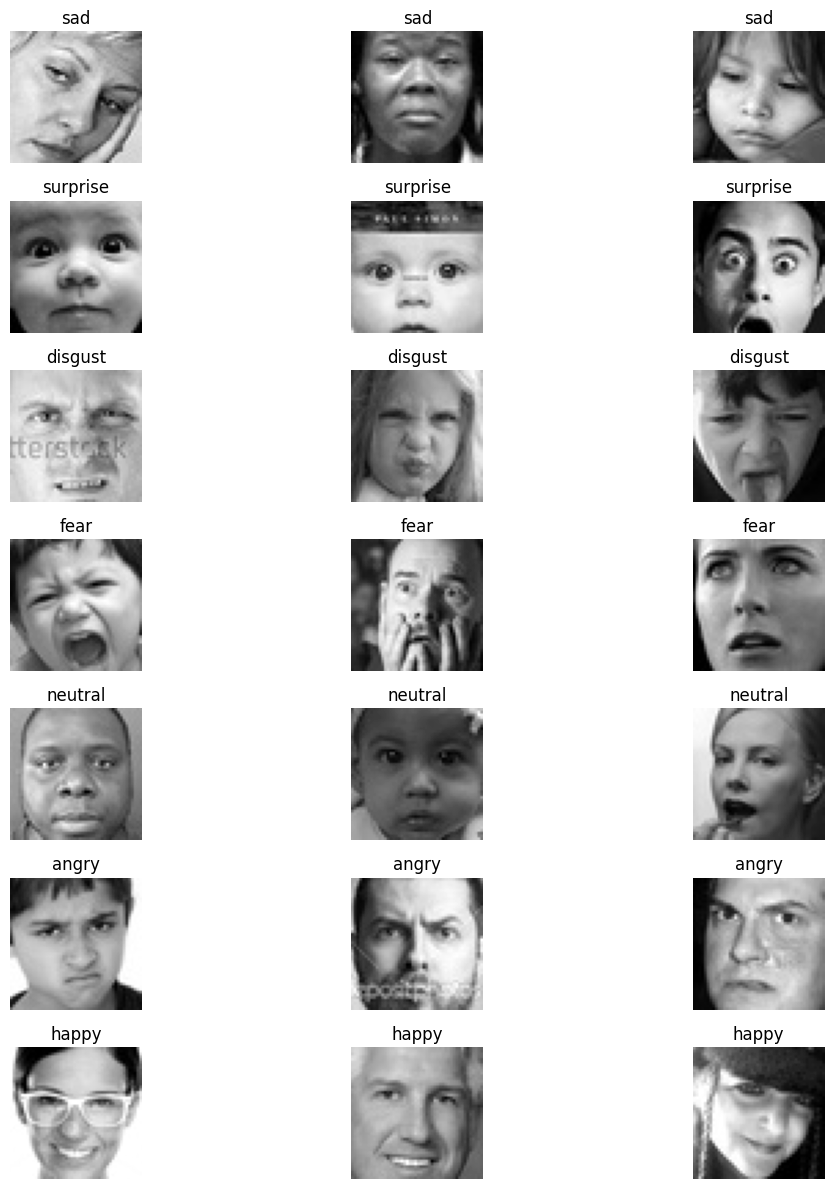

In [3]:
# Path to the unzipped dataset
FACE_EXP_FOLDER_PATH = "Face_expression_recognition_dataset/images/"
PICTURE_SIZE = 48

# Lists the categories (subdirectories) within the training data directory to display sample images from the face expression dataset.
expression_categories = os.listdir(os.path.join(FACE_EXP_FOLDER_PATH, "train"))

# Display and explore data samples
plt.figure(figsize=(12, 12))
for i, expression in enumerate(expression_categories):
    expression_folder_path = os.path.join(FACE_EXP_FOLDER_PATH, "train", expression)
    for j in range(3):  # Display 3 images per category
        img_path = os.path.join(expression_folder_path, os.listdir(expression_folder_path)[j])
        img = load_img(img_path, target_size=(PICTURE_SIZE, PICTURE_SIZE), color_mode='grayscale')
        plt.subplot(len(expression_categories), 3, i * 3 + j + 1)
        plt.imshow(img, cmap='gray')
        plt.title(expression)
        plt.axis('off')
plt.tight_layout()
plt.show()

### **STEP 3: Data Preprocessing & Augmentation**
Preprocessing and augmentation enhance model robustness by standardizing input data and increasing dataset diversity, improving generalization and performance.

<b>`ImageDataGenerator()`</b> :
    - Used for real-time data augmentation, which enhances model generalization and robustness by generating varied training examples
      from existing data.

<b>`rescale=1. / 255`</b> :
    - Scales pixel values to the range [0,1], aiding convergence during training.
    
<b>`rotation_range=20`</b> :
    - Introduces random rotations of up to 20 degrees during data augmentation, enhancing model robustness to variations in input images.

<b>`width_shift_range=0.2`</b> :
    - Randomly shift the width of images during data augmentation, increasing model robustness to variations in object position.
    
<b>`height_shift_range=0.2`</b> :
    - Introduce vertical shifts of up to 20% of the image height, enhancing robustness against positional variations in the dataset.
    
<b>`shear_range=0.2`</b> :
    - Introduce shearing transformations in data augmentation, enhancing model robustness to variations in input images.
    
<b>`zoom_range=0.2`</b> :
    - To apply random zoom augmentation during training, increasing model robustness to variations in input size.

<b>`horizontal_flip=True`</b> :
    - To augment the dataset by horizontally flipping images, increasing variability and robustness of the model.

<b>`fill_mode='nearest'`</b> :
    - Used to fill in missing pixels during data augmentation by replicating the nearest existing pixel value.

<b>` datagen_train.flow_from_directory`</b> :
    - Simplifies the process of loading and augmenting image data from directories, streamlining training.

<b>`os.path.join(FACE_EXP_FOLDER_PATH, "train")`</b> :
    - Combines path components, ensuring compatibility across different operating systems.

<b>`target_size=(PICTURE_SIZE, PICTURE_SIZE)`</b> :
    - Used to resize images to a specific size, ensuring uniformity in input dimensions for the model.

<b>`color_mode="grayscale"`</b> :
    - Ensures that the images are loaded in grayscale mode, reducing computational complexity by eliminating unnecessary color channels.

<b>`batch_size=128`</b> :
    - Allows for efficient training by processing multiple samples simultaneously, optimizing GPU memory usage.

<b>`class_mode='categorical'`</b> :
    - To handle multi-class classification tasks where each image belongs to one of several predefined classes.

<b>`shuffle=True`</b> :
    - Randomizes the order of training samples, preventing the model from learning the sequence and improving generalization.

In [4]:
datagen_train = ImageDataGenerator(    # Enhances model generalization and robustness by generating varied training examples from existing data
    rescale=1. / 255,   #
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1. / 255)

train_set = datagen_train.flow_from_directory(
    os.path.join(FACE_EXP_FOLDER_PATH, "train"),
    target_size=(PICTURE_SIZE, PICTURE_SIZE),
    color_mode="grayscale",
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    os.path.join(FACE_EXP_FOLDER_PATH, "validation"),
    target_size=(PICTURE_SIZE, PICTURE_SIZE),
    color_mode="grayscale",
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### **STEP 4: Define Model Architecture**
Built a Sequential model with multiple convolutional layers followed by batch normalization, ReLU activation, max-pooling, and dropout layers.

<b>`Sequential()`</b> :
    - Simple, easy to implement model, and suitable for straightforward layer stacks.

<b>`model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))`</b> :
    - Extracts features with 64 filters of size 3x3, maintains input dimensions (48x48 grayscale), and preserves spatial size using 'same' padding.

<b>`model.add(BatchNormalization())`</b> :
    - Normalize data within each mini-batch, enhancing training speed and stability.

<b>`model.add(Activation('relu'))`</b> :
    - Introduce non-linearity, enabling the model to learn complex patterns.

<b>`model.add(MaxPooling2D(pool_size=(2, 2))) `</b> :
    - Reduce spatial dimensions and computational load while retaining important features.

<b>`model.add(Dropout(0.25))`</b> :
    - Prevent overfitting by randomly dropping 25% of neurons during training.

<b>`model.add(Flatten())`</b> :
    - Convert the 2D matrix to a 1D vector for the fully connected layers.

<b>`model.add(Dense(512))`</b> :
    - Used to add a fully connected layer with 512 neurons for learning complex patterns.

<b>`model.add(Dense(NO_OF_CLASSES, activation='softmax'))`</b> :
    - To output probabilities across classes.

<b>`opt = Adam(learning_rate=0.0001)`</b> :
    - Optimize the model's learning process with a specific learning rate.

<b>`model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])`</b> :
    - To configure the model for training by specifying the optimizer, loss function, and evaluation metric, ensuring efficient training and
      performance evaluation.

<b>`model.summary()`</b> :
    - Provides a concise overview of the network architecture and parameter counts, aiding in model understanding and debugging.

In [5]:
NO_OF_CLASSES = 7

expression_model = Sequential()

expression_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(MaxPooling2D(pool_size=(2, 2)))
expression_model.add(Dropout(0.25))

expression_model.add(Conv2D(128, (5, 5), padding='same'))
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(MaxPooling2D(pool_size=(2, 2)))
expression_model.add(Dropout(0.25))

expression_model.add(Conv2D(512, (3, 3), padding='same'))
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(MaxPooling2D(pool_size=(2, 2)))
expression_model.add(Dropout(0.25))

expression_model.add(Conv2D(512, (3, 3), padding='same'))
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(MaxPooling2D(pool_size=(2, 2)))
expression_model.add(Dropout(0.25))

expression_model.add(Flatten())
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(Dropout(0.25))

expression_model.add(Dense(512))
expression_model.add(BatchNormalization())
expression_model.add(Activation('relu'))
expression_model.add(Dropout(0.25))

expression_model.add(Dense(NO_OF_CLASSES, activation='softmax'))

opt = Adam(learning_rate=0.0001)
expression_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
expression_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### **STEP 5: Train Model**
Train the model using the training and validation data generators, with a specified number of epochs and steps per epoch.

*   Used `EarlyStopping` to stop training when the validation loss stops improving, restoring the best model weights.
*   Used `ModelCheckpoint` to save the best model based on validation accuracy.
*   Used `ReduceLROnPlateau` to reduce the learning rate when the validation loss plateaus, helping the model to converge better.


In [6]:
# Callbacks:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True),
    ModelCheckpoint('expression_model.keras' , monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_delta=0.0001)
]

In [7]:
# Monitor and Optimize the Model
history = expression_model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=200,
    validation_data=val_set,
    validation_steps=val_set.n // val_set.batch_size,
    callbacks=callbacks
)

Epoch 1/200
225/225 [==============================] - ETA: 0s - loss: 2.0936 - accuracy: 0.2120
Epoch 1: val_accuracy improved from -inf to 0.25923, saving model to expression_model.keras
225/225 [==============================] - 41s 138ms/step - loss: 2.0936 - accuracy: 0.2120 - val_loss: 1.8778 - val_accuracy: 0.2592 - lr: 1.0000e-04
Epoch 2/200
225/225 [==============================] - ETA: 0s - loss: 1.9361 - accuracy: 0.2327
Epoch 2: val_accuracy improved from 0.25923 to 0.26349, saving model to expression_model.keras
225/225 [==============================] - 29s 127ms/step - loss: 1.9361 - accuracy: 0.2327 - val_loss: 1.8309 - val_accuracy: 0.2635 - lr: 1.0000e-04
Epoch 3/200
225/225 [==============================] - ETA: 0s - loss: 1.8894 - accuracy: 0.2374
Epoch 3: val_accuracy improved from 0.26349 to 0.26705, saving model to expression_model.keras
225/225 [==============================] - 28s 126ms/step - loss: 1.8894 - accuracy: 0.2374 - val_loss: 1.7821 - val_accuracy

### **STEP 6: Plot the Accuracy & Loss results**

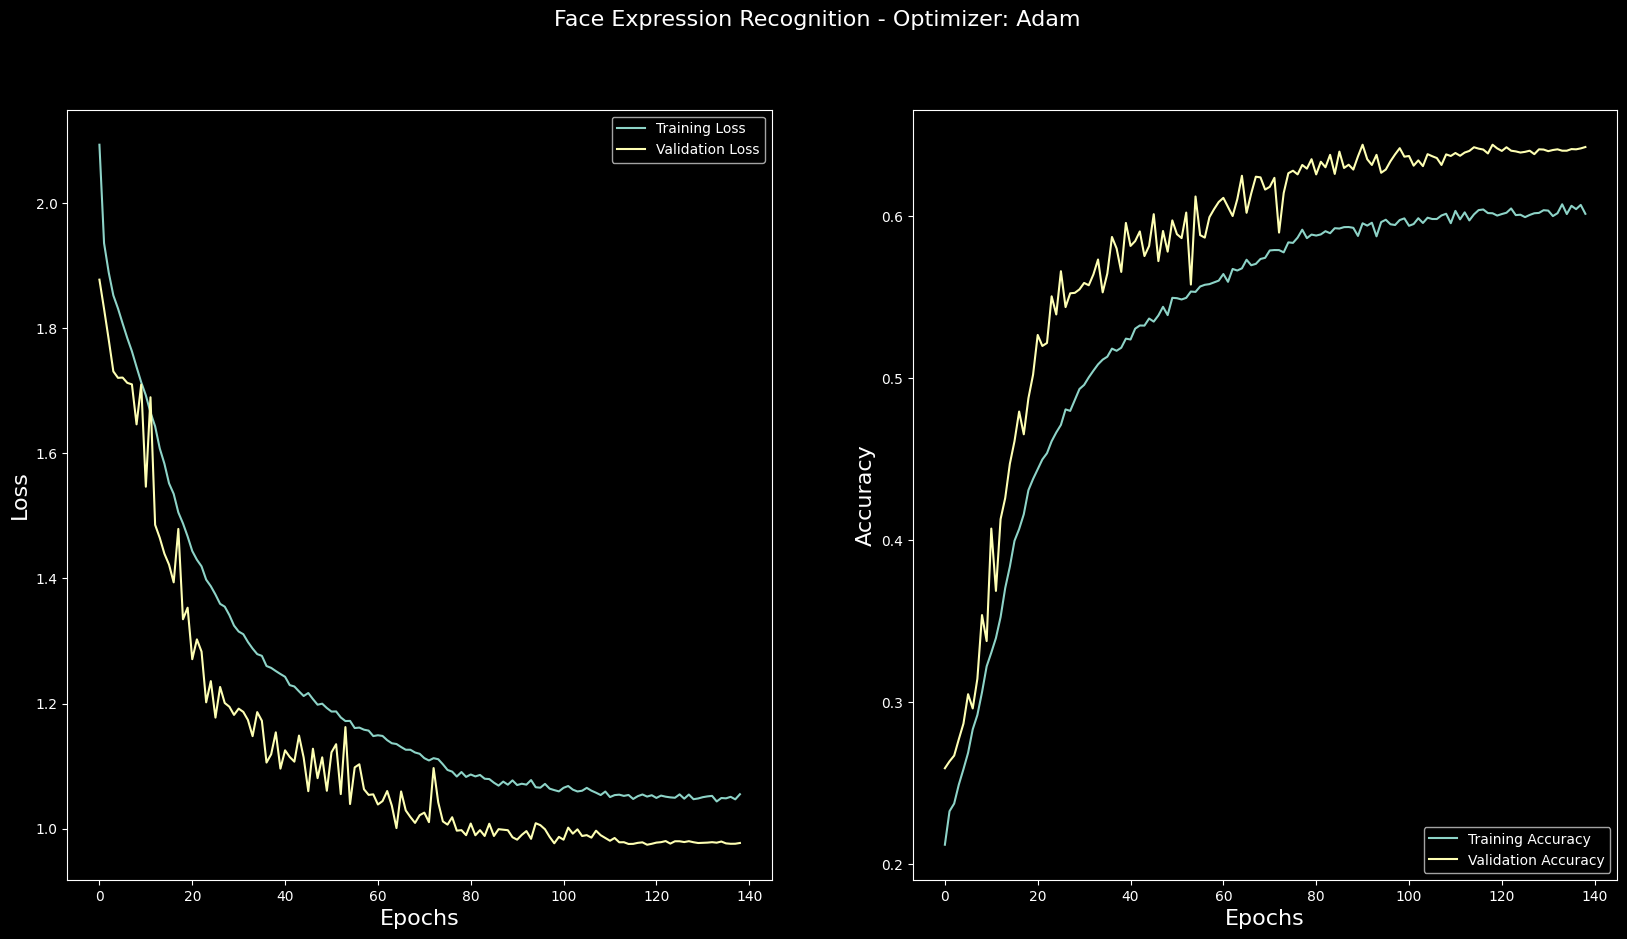

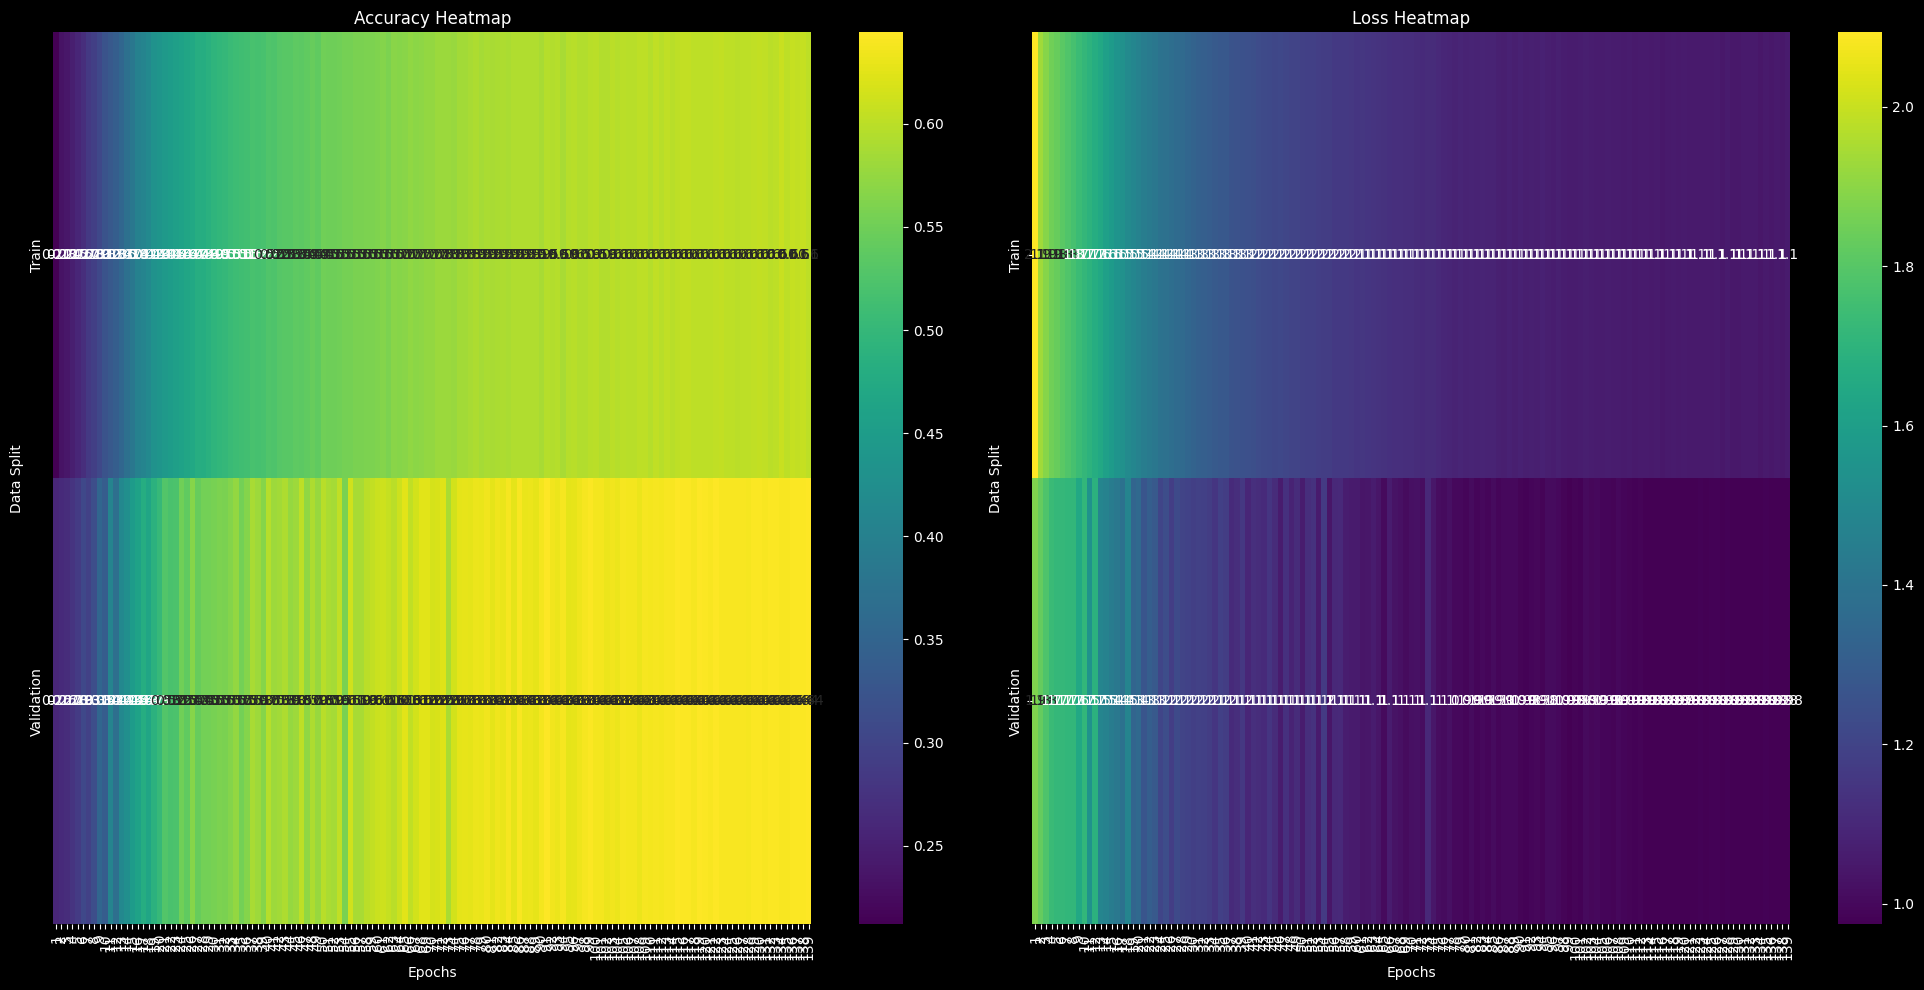

In [8]:
# Plot Results
plt.style.use('dark_background')
plt.figure(figsize=(20, 10))

# Plot loss
plt.subplot(1, 2, 1)
plt.suptitle('Face Expression Recognition - Optimizer: Adam', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

# Plotting heatmaps
def plot_heatmap(history, metric, title):
    epochs = range(1, len(history.history[metric]) + 1)
    data = np.array([history.history[metric], history.history[f'val_{metric}']])
    sns.heatmap(data, annot=True, xticklabels=epochs, yticklabels=['Train', 'Validation'], cmap='viridis')
    plt.xlabel('Epochs')
    plt.ylabel('Data Split')
    plt.title(title)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plot_heatmap(history, 'accuracy', 'Accuracy Heatmap')

plt.subplot(1, 2, 2)
plot_heatmap(history, 'loss', 'Loss Heatmap')

plt.tight_layout()
plt.show()


# Frågeställningar:

Utmaningar och hantering: Jag har mött utmaningar under kursens gång, särskilt när det gällde att förstå komplexa ämnen. För att hantera detta har jag aktivt läst kursmaterial, sökt information på nätet och använt mig av handledande material såsom tutorials och DataCamp-kurser för att förbättra min förståelse.

Betyg och motivering: Jag anser att jag förtjänar ett G-betyg eftersom jag har gjort allt jag kan för att slutföra kursen och uppfylla dess krav.

Tips till mig själv: Skapa en tydlig tidsplan för att hantera arbetsbördan effektivt. Var proaktiv med att söka stöd från lärare och kurskamrater och arbeta tillsammans för att underlätta inlärningsprocessen.